In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Toxic Comment Classification Challenge
- topic : NLP, binary classification, Data Visulization, Data Analysis
- Model Selected : ***Logistic Regression***
- score : 0.96963 (private)

In [2]:
import re
import numpy as np
import pandas as pd

# visualization
import missingno as msno # missing value check
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences


# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


# evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings(action='ignore') 

# 1. Data Load
##### Dataset Info
- Train data : 159571
- Test data :  153164

- **missing value**: none

##### columns of data
- 'id' : Unique for each record
- 'comment_text' : Columns used for classification
- 'toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'
    - Binary classification predicting 0, 1 for each column 
    - i.e. 6 binary classifications

In [3]:
import os
file_list = []
for dirname, _, filenames in os.walk(r'D:\T431 - George Brown\Adv Math for ML 2\Final Project'):
    for filename in filenames:
        file_list.append(os.path.join(dirname, filename))
        
# import zipfile
# for i in range(len(file_list)):
#     with zipfile.ZipFile(file_list[i],"r") as z:
#         z.extractall(".")
        
# load data
train = pd.read_csv('drive/MyDrive/TermProject/train.csv')
test = pd.read_csv('drive/MyDrive/TermProject/test.csv')

# submission example
submission = pd.read_csv('drive/MyDrive/TermProject/sample_submission.csv')
test_labels = pd.read_csv('drive/MyDrive/TermProject/test_labels.csv')

print("train data length: ", len(train))
print("test data length: ", len(test))

train data length:  159571
test data length:  153164


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [6]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

In [7]:
# Check missing value
print(train.isnull().value_counts())
print('-'*30)
print(train.isnull().sum())

id     comment_text  toxic  severe_toxic  obscene  threat  insult  identity_hate
False  False         False  False         False    False   False   False            159571
dtype: int64
------------------------------
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [8]:
# data size
print('size of train : {}'.format(len(train)))
print('size of test : {}'.format(len(test)))
print('-'*20)
print(train[target_cols].sum().sort_values(ascending=False))

size of train : 159571
size of test : 153164
--------------------
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


Word Cloud

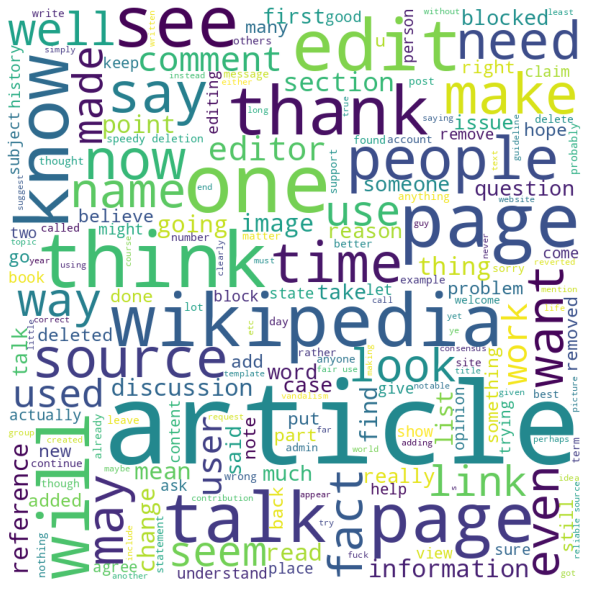

In [31]:

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 

df = train
 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.comment_text:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# EDA
- Text Preprocessing
- Removing stop words and abbreviations
- Remove punctuations
- Decide whether to remove repeating words

In [9]:

train['sum_harmful'] = 0
for col in target_cols:
    train['sum_harmful'] += train[col]
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [10]:
# Before preprocessing text, check text length distribution
train['len_of_text'] = train['comment_text'].apply(len)

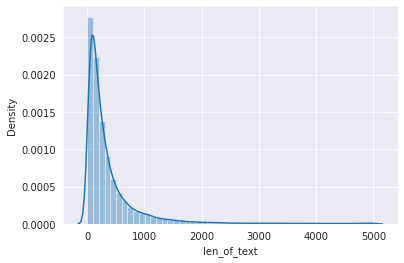

In [11]:
# Visualize text length distribution
sns.set_style("darkgrid")
sns.distplot(train['len_of_text'],kde=True)
plt.show()

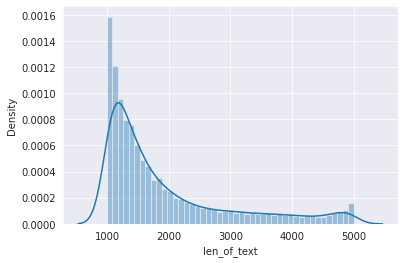

In [12]:
# Visualizing text lengths greater than 1000
x = train.loc[train['len_of_text'] > 1000,'len_of_text']
sns.distplot(x,kde=True)
plt.show()

0    12521
1      419
3      146
2      128
4      121
5       23
6        2
Name: sum_harmful, dtype: int64


<AxesSubplot:xlabel='sum_harmful', ylabel='count'>

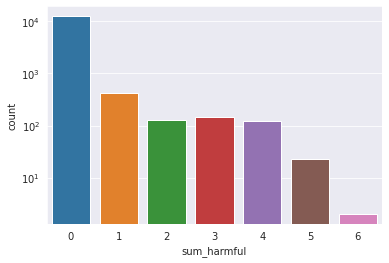

In [13]:
# Sum of the number of target_cols of data greater than 1000 classified as 1
print(train.loc[train['len_of_text'] > 1000,'sum_harmful'].value_counts())

plt.yscale('log')
display(sns.countplot(train.loc[train['len_of_text'] > 1000,'sum_harmful']))

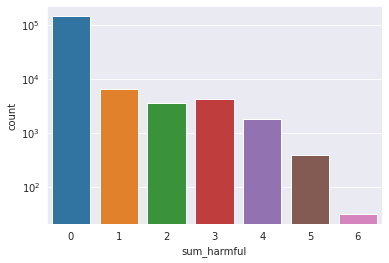

In [14]:
# Above 1000 looks similar to the existing data distribution - > does not handle outliers
plt.yscale('log')
sns.countplot(train['sum_harmful'])
plt.show()

In [15]:
train['sum_harmful'].value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: sum_harmful, dtype: int64

In [16]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.219952,394.073221
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.748260,590.720282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,435.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5000.000000


# 1. Text Preprocessing - Replace abbreviation

In [17]:
# is, has, have 등 동사 줄임 처리
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [18]:
train['preprocess_text'] = train['comment_text'].apply(clean_text)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text,preprocess_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,d aww he matches this background colour i am s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,hey man i am really not trying to edit war it ...


# 2. Text Preprocessing - Stop Words Removed
- Create a stop word list using Countvectorizer
- Remove stop words - use the stopwords provided by NLTK together with the list of stop words created above

In [19]:
# applying CountVectorizer to entire dat
cv = CountVectorizer() # If set to n-gram in (up to 2-gram)ngram_range = (1, 3)
documents = train.comment_text.tolist()
documents = [' '.join(documents)] 

X = cv.fit_transform(documents).toarray()
freqs = X.transpose().flatten() # One-dimensional, arrayed encoding vectors spread out in one dimension
words = cv.get_feature_names_out() # Array mapping from feature integer indices to feature name.

df_word = pd.DataFrame({'word': words, 'freq': freqs})
df_word = df_word.sort_values(by='freq', ascending=False)

df_word = df_word.reset_index().drop(['index'],axis=1)
df_word[:10]

,word,freq
0,the,496796
1,to,297408
2,of,224547
3,and,224092
4,you,218308
5,is,176405
6,that,160867
7,it,148644
8,in,145477
9,for,102723


In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stopwords_list = df_word.word.tolist()[:70]
print('Number of stop words created from training data: ',len(stopwords_list))
print(stopwords_list[:10],'...')

# Using NLTK's Stopwords
from nltk.corpus import stopwords
stopwords_list+=stopwords.words('english')
stopwords = set(stopwords_list)
print(' ')
print("Final stopwords count :", len(stopwords))

Number of stop words created from training data:  70
['the', 'to', 'of', 'and', 'you', 'is', 'that', 'it', 'in', 'for'] ...
 
Final stopwords count : 192


In [22]:
from nltk.tokenize import word_tokenize

# Use NLTK's tokenizer to tokenize, remove stop words, remove tokens less than 2 in length
def remove_stopwords(text):
    stopwords_list = stopwords
    word_tokens = word_tokenize(text)
    result = []
    for w in word_tokens:
        if len(w)>2 and w not in stopwords_list:
            result.append(w)
    return ' '.join(result)

# Remove everything except English, lowercase
def remove_special(text, lower=True):
    if lower:
        text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join(
        text.split()
    )
    return text

def remove_repeat(text, repeat=1):
    text = text.split(' ')
    result = []
    for word in text:
        if result.count(word)<repeat:
            result.append(word)
    return ' '.join(result)

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
train['preprocess_text'] = train['preprocess_text'].apply(remove_special)
train['preprocess_text'] = train['preprocess_text'].apply(remove_stopwords)

In [25]:
test['preprocess_text'] = test['comment_text'].apply(clean_text)
test['preprocess_text'] = test['preprocess_text'].apply(remove_special)
test['preprocess_text'] = test['preprocess_text'].apply(remove_stopwords)

# 3. Text preprocessing - decide whether to remove repetitions

count    159571.000000
mean         31.193506
std          49.602668
min           1.000000
25%           7.000000
50%          16.000000
75%          34.000000
max        1250.000000
Name: preprocess_text, dtype: float64


<AxesSubplot:xlabel='preprocess_text', ylabel='Density'>

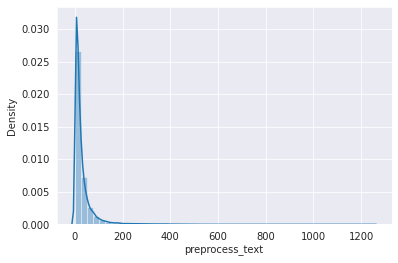

In [26]:
# Word Count
def num_of_word(text):
    return len(text.split(' '))

tmp = train['preprocess_text'].apply(num_of_word)
print(tmp.describe())
sns.distplot(tmp)

### Word count
- 75% of words are 34 or less
- But max = 1250, which is very large
- Let's look at more than 500 and more than 1000 pieces of data.

In [27]:
train['num_of_word'] = train['preprocess_text'].apply(num_of_word)
display(train[(train['num_of_word'] > 500)&(train['num_of_word'] < 1000)].head(3))
display(train[train['num_of_word'] > 1000])

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text,preprocess_text,num_of_word
2420,067c5e814e88a56b,FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT ...,1,1,1,0,1,0,4,4999,fuck useless bot fuck useless bot fuck useless...,652
4174,0b2055f13934a41e,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,0,1,0,1,0,3,5000,still post computer said block come fuck arres...,520
4712,0c7c341727488579,do go fuck off bastard\nDo Yyou Have a life?\n...,1,1,1,1,1,0,5,4969,fuck bastard yyou life fuck bastard yank cock ...,700


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text,preprocess_text,num_of_word
6572,118e2e7cd2b30188,Sex sex sex sex Sex sex sex sexSex sex sex sex...,1,0,0,0,0,0,1,4999,sex sex sex sex sex sex sex sexsex sex sex sex...,1001
32143,5572234220e43ea2,PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PI...,1,0,0,0,0,0,1,4999,pig pig pig pig pig pig pig pig pig pig pig pi...,1250
32400,56311e1c0b2cbb52,THAT WAS REALLY MILLESECONDS WASNT IT BITCH \n...,1,0,1,0,1,1,4,4981,really milleseconds wasnt bitch fat jew fat je...,1235
76598,cd135d9358a9e9ea,DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FA...,1,0,0,0,0,0,1,4999,die fag die fag die fag die fag die fag die fa...,1250
150039,65d66bf057752682,LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LO...,0,0,0,0,0,0,0,4999,lol lol lol lol lol lol lol lol lol lol lol lo...,1250
153353,9bb20c51c9fec236,FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JE...,1,0,0,0,1,1,3,4999,fat jew fat jew fat jew fat jew fat jew fat je...,1247


If the number of words is large it might lead to incorrect results
 --> If we get rid of this, will the model catch fewer of these trends?
- Model performance comparison experiment before and after removal

In [28]:
# Create and save a separate column for deduplication performance comparison
train['remove_repeat'] = train['preprocess_text'].apply(remove_repeat)
test['remove_repeat'] = test['preprocess_text'].apply(remove_repeat)

display(train.head(3))
display(test.head(3))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text,preprocess_text,num_of_word,remove_repeat
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,explanation edits made username hardcore metal...,20,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,aww matches background colour seemingly stuck ...,9,aww matches background colour seemingly stuck ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,hey man really trying edit war guy constantly ...,19,hey man really trying edit war guy constantly ...


,id,comment_text,preprocess_text,remove_repeat
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succesful ever whats hating sad mof...,bitch rule succesful ever whats hating sad mof...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,rfc title fine imo,rfc title fine imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sources zawe ashton lapland,sources zawe ashton lapland


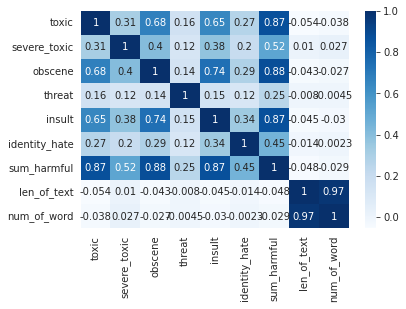

In [29]:
# Correlation of columns - heatmap
corr_matrix = train.corr()
sns.heatmap(corr_matrix, cmap='Blues',annot=True)
plt.show()

# TFIDF vectorization
- min_df : The minimum df value to vectorize (less than this value is not vectorized)
- analyzer : 
    - 'word': units are words
    - 'char': units are characters 
- sublinear_tf : Whether to smooth the word frequency (TF) of the document.
- ngram_range : Set the range of n-grams, the basic unit for calculating frequencies
- max_features : Maximum length of each vector
    - If this value is not set, a very sparse matrix will be generated if there are many featrue (many words/tokens).

## 1. Logistic Regression

### 1.1 Training with text before repetition

In [37]:
preprocess_text = train.preprocess_text

vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(preprocess_text)
y = train[target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

print('X_train len: ', X_train.shape[0])
print('X_valid len:  ',  X_valid.shape[0])

X_train len:  127656
X_valid len:   31915


In [38]:
from collections import defaultdict
accuracy_data = defaultdict(list)
for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    print(' ')
    y = y_train[col]
    log_reg = LogisticRegression()
    log_reg.fit(X_train,y)
    y_pred_lr = log_reg.predict(X_valid)
    print('Testing accuracy is {}'.format(round(accuracy_score(y_valid[col], y_pred_lr),5)))
    accuracy_data[col].append(round(accuracy_score(y_valid[col], y_pred_lr),5))

 
----prediction of toxic column----
 
Testing accuracy is 0.9571
 
----prediction of severe_toxic column----
 
Testing accuracy is 0.99
 
----prediction of obscene column----
 
Testing accuracy is 0.97735
 
----prediction of threat column----
 
Testing accuracy is 0.99727
 
----prediction of insult column----
 
Testing accuracy is 0.97026
 
----prediction of identity_hate column----
 
Testing accuracy is 0.99201


### 1.2 Training after removing repetitions

In [39]:
remove_repeat_text = train.remove_repeat

vectorizer2 = TfidfVectorizer(max_features=5000)

X2 = vectorizer2.fit_transform(remove_repeat_text)
y = train[target_cols]

X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y, test_size=0.2, random_state=0)

print('X_train len: ', X_train2.shape[0])
print('X_valid len:  ',  X_valid2.shape[0])

X_train len:  127656
X_valid len:   31915


In [40]:
# model2
for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    print(' ')
    y = y_train2[col]
    log_reg2 = LogisticRegression()
    log_reg2.fit(X_train2,y)
    y_pred_lr2 = log_reg2.predict(X_valid2)
    print('Testing accuracy is {}'.format(round(accuracy_score(y_valid2[col], y_pred_lr2),5)))
    accuracy_data[col].append(round(accuracy_score(y_valid2[col], y_pred_lr2),5))

 
----prediction of toxic column----
 
Testing accuracy is 0.95598
 
----prediction of severe_toxic column----
 
Testing accuracy is 0.98985
 
----prediction of obscene column----
 
Testing accuracy is 0.97663
 
----prediction of threat column----
 
Testing accuracy is 0.99727
 
----prediction of insult column----
 
Testing accuracy is 0.96973
 
----prediction of identity_hate column----
 
Testing accuracy is 0.99157


In [41]:
tmp = pd.DataFrame(accuracy_data, index=['allow_rep','remove_rep'])
tmp

,toxic,severe_toxic,obscene,threat,insult,identity_hate
allow_rep,0.95710,0.99000,0.97735,0.99727,0.97026,0.99201
remove_rep,0.95598,0.98985,0.97663,0.99727,0.96973,0.99157


## 2a. Decision Tree Classification

2a.1 Training with text before repetition

In [42]:
for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    print(' ')
    y = y_train[col]
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
    dtree.fit(X_train,y)
    y_pred_dt = dtree.predict(X_valid)
    print('Testing accuracy is {}'.format(round(accuracy_score(y_valid[col], y_pred_dt),5)))
    accuracy_data[col].append(round(accuracy_score(y_valid[col], y_pred_dt),5))

 
----prediction of toxic column----
 
Testing accuracy is 0.93285
 
----prediction of severe_toxic column----
 
Testing accuracy is 0.98963
 
----prediction of obscene column----
 
Testing accuracy is 0.97099
 
----prediction of threat column----
 
Testing accuracy is 0.99715
 
----prediction of insult column----
 
Testing accuracy is 0.96494
 
----prediction of identity_hate column----
 
Testing accuracy is 0.99176


### 2a.2 Training after removing repetitions

In [43]:
for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    print(' ')
    y = y_train2[col]
    dtree2 = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
    dtree2.fit(X_train2,y)
    y_pred_dt2 = dtree2.predict(X_valid2)
    print('Testing accuracy is {}'.format(round(accuracy_score(y_valid2[col], y_pred_dt2),5)))
    accuracy_data[col].append(round(accuracy_score(y_valid2[col], y_pred_dt2),5))

 
----prediction of toxic column----
 
Testing accuracy is 0.93304
 
----prediction of severe_toxic column----
 
Testing accuracy is 0.98966
 
----prediction of obscene column----
 
Testing accuracy is 0.97146
 
----prediction of threat column----
 
Testing accuracy is 0.99696
 
----prediction of insult column----
 
Testing accuracy is 0.96475
 
----prediction of identity_hate column----
 
Testing accuracy is 0.99138


## 2b. Random Forest Classification

### 2b.1 Training with text before repetition

In [44]:
for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    print(' ')
    y = y_train[col]
    random_forest = RandomForestClassifier(criterion='gini', n_estimators=5, n_jobs=2, random_state=0)
    random_forest.fit(X_train,y)
    y_pred_rf = random_forest.predict(X_valid)
    print('Testing accuracy is {}'.format(round(accuracy_score(y_valid[col], y_pred_rf),5)))
    accuracy_data[col].append(round(accuracy_score(y_valid[col], y_pred_rf),5))

 
----prediction of toxic column----
 
Testing accuracy is 0.94965
 
----prediction of severe_toxic column----
 
Testing accuracy is 0.98916
 
----prediction of obscene column----
 
Testing accuracy is 0.9755
 
----prediction of threat column----
 
Testing accuracy is 0.99709
 
----prediction of insult column----
 
Testing accuracy is 0.9645
 
----prediction of identity_hate column----
 
Testing accuracy is 0.99126


### 2b.2 Training after removing repetitions

In [45]:
for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    print(' ')
    y = y_train2[col]
    random_forest2 = RandomForestClassifier(criterion='gini', n_estimators=5, n_jobs=2, random_state=0)
    random_forest2.fit(X_train2,y)
    y_pred_rf2 = random_forest.predict(X_valid2)
    print('Testing accuracy is {}'.format(round(accuracy_score(y_valid2[col], y_pred_rf2),5)))
    accuracy_data[col].append(round(accuracy_score(y_valid2[col], y_pred_rf2),5))

 
----prediction of toxic column----
 
Testing accuracy is 0.89964
 
----prediction of severe_toxic column----
 
Testing accuracy is 0.98587
 
----prediction of obscene column----
 
Testing accuracy is 0.94316
 
----prediction of threat column----
 
Testing accuracy is 0.9932
 
----prediction of insult column----
 
Testing accuracy is 0.94636
 
----prediction of identity_hate column----
 
Testing accuracy is 0.9869


### Train Test Split

In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               159571 non-null  object
 1   comment_text     159571 non-null  object
 2   toxic            159571 non-null  int64 
 3   severe_toxic     159571 non-null  int64 
 4   obscene          159571 non-null  int64 
 5   threat           159571 non-null  int64 
 6   insult           159571 non-null  int64 
 7   identity_hate    159571 non-null  int64 
 8   sum_harmful      159571 non-null  int64 
 9   len_of_text      159571 non-null  int64 
 10  preprocess_text  159571 non-null  object
 11  num_of_word      159571 non-null  int64 
 12  remove_repeat    159571 non-null  object
dtypes: int64(9), object(4)
memory usage: 15.8+ MB
None


In [ ]:
print(train.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'sum_harmful', 'len_of_text',
       'preprocess_text', 'num_of_word', 'remove_repeat'],
      dtype='object')


In [ ]:
X = train.iloc[:,-3:-2]
X

,preprocess_text
0,explanation edits made username hardcore metal...
1,aww matches background colour seemingly stuck ...
2,hey man really trying edit war guy constantly ...
3,make real suggestions improvement wondered sec...
4,sir hero chance remember
...,...
159566,second time asking view completely contradicts...
159567,ashamed horrible thing put
159568,spitzer umm theres actual prostitution ring cr...
159569,looks actually put speedy first version delete...


In [ ]:
y = train.iloc[:,2:8]
y

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(106912, 1)
(106912, 6)
(52659, 1)
(52659, 6)
